# Week 11 - Introduction to Modeling, part 2

# 1. Lesson - No lesson this week

# 2. Weekly graph question

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

The book names one of Vonnegut's rules as "keep it simple" and another as "have the guts to cut."  Here is some data from the previous week's lesson.  If you had to cut one of the two plots below, which would it be?  Which seems more interesting or important?  Explain.  (Should "amount of training data used" or "number of estimators" be on the x-axis.)

- I would cut the number of estimators plot. It's clear there is very little advantage beyond 10 trees. We could stop fitting our Random Forest model at this point.
- The training data relationship is quite interesting. We often pick an arbitrary training set amount and seeing how this relates to our loss function helps us see, for this dataset, how there is only a minor improvement after 12.5.
- It makes sense that the amount of training data and the number of estimators are on each x axis and the Loss function is on the y-axis. They are the indepedent variables and it is easier to see the relationship this way.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

In [3]:
rmse_lst = list()
rf = RandomForestRegressor()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss function')

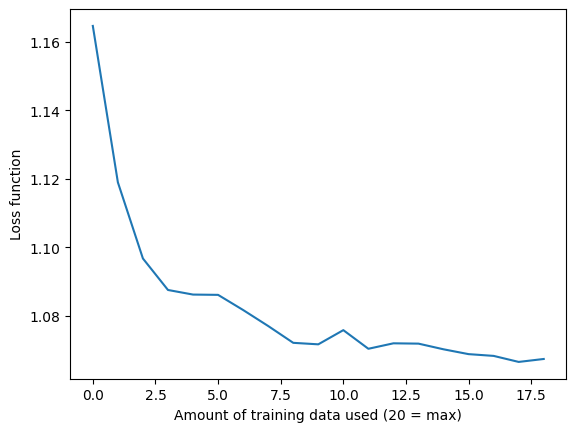

In [4]:
plt.plot(rmse_lst)
plt.xlabel("Amount of training data used (20 = max)")
plt.ylabel("Loss function")

In [5]:
num_trees_lst = list()
for n_estimators in range(1, 100, 3):
    rf = RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(train_df.values, train_target)
    num_trees_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

Text(0, 0.5, 'Loss function')

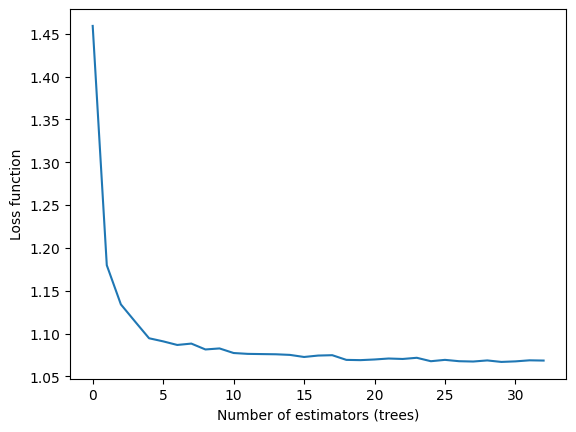

In [6]:
plt.plot(num_trees_lst)
plt.xlabel("Number of estimators (trees)")
plt.ylabel("Loss function")

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

Here are some types of analysis you can do:

* Implement a random forest model.
* Perform cross-validation.
* Tune hyperparameters.
* Evaluate a performance metric.

If you like, you can try other types of models, too (beyond linear regression and random forest) although you will have many opportunities to do that next semester.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter seven (p. 165-185) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

# Working on my datasets

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from scipy.stats import zscore, randint, uniform

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

seed = 42

## Generic Functions

In [74]:

def train_random_forest(X, y, scale_numeric=False, cv=3):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Optional scaling
    if scale_numeric:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Train model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Training MAE
    y_pred_train = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)

    # Cross-validation MAE
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
    mean_cv_mae = -np.mean(cv_scores)
    std_cv_mae = np.std(cv_scores)

    print(f"Training MAE: {train_mae:.2f}")
    print(f"Mean CV MAE: {mean_cv_mae:.2f}")
    print(f"CV MAE Std Dev: {std_cv_mae:.2f}")

    # Get feature importances
    importances = model.feature_importances_
    feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Top 10 most important features
    top_10 = feature_importance_df.head(10)
    plt.figure(figsize=(10, 6))
    plt.barh(top_10['Feature'][::-1], top_10['Importance'][::-1])
    plt.title('Top 10 Most Important Features')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    # Bottom 10 least important features
    bottom_10 = feature_importance_df.tail(10)
    plt.figure(figsize=(10, 6))
    plt.barh(bottom_10['Feature'], bottom_10['Importance'])
    plt.title('10 Least Important Features')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return model




In [75]:

def random_search_random_forest(X, y, scale_numeric=False, n_iter=20, cv=3, random_state=42, param_distributions=None):

    # Identify column types
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

    # Preprocessing for numeric columns
    if scale_numeric:
        num_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
    else:
        num_transformer = SimpleImputer(strategy='mean')

    # Preprocessing for categorical columns
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    # Combine preprocessing
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ])

    # Full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=random_state))
    ])

    # Hyperparameter grid
    if param_distributions is None:
        param_distributions = {
            'regressor__n_estimators': [50, 100, 200, 300],
            'regressor__max_depth': [None, 10, 20, 30, 40],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__max_features': ['sqrt', 'log2']
        }

    # Randomized search
    search = RandomizedSearchCV(pipeline, param_distributions, n_iter=n_iter, cv=cv,
                                scoring='neg_mean_absolute_error', random_state=random_state,
                                return_train_score=True, n_jobs=-1)

    search.fit(X, y)

    # Log results
    results = pd.DataFrame(search.cv_results_)
    results['mean_absolute_error'] = -results['mean_test_score']
    results_sorted = results.sort_values(by='mean_absolute_error')

    # Print each iteration's results
    for i, row in results_sorted.iterrows():
        print(f"Iteration {i+1}: MAE = {row['mean_absolute_error']:.2f}, Params = {row['params']}")

    print("\nBest Parameters:")
    print(search.best_params_)
    print(f"Best CV MAE: {-search.best_score_:.2f}")

    return search.best_estimator_, results_sorted



## Priceline Data

In [ ]:

def clean_priceline_data(df, target_column):
    # Filter out rows with nulls in specific columns
    df = df[df['destination_airport'].notnull()]
    df = df[df['departure_airport'].notnull()]
    df = df[df['airline_name'].notnull()]
    df = df[df['travel_time_minutes'].notnull()]

    # Filter rows with more than half columns blank
    threshold = df.shape[1] // 2
    df = df[df.isnull().sum(axis=1) <= threshold]

    # Drop specified columns
    df = df.drop(columns=['2nd_stoppage', '3rd_stoppage'], errors='ignore')

    # Create new column for total stop wait time
    df['total_stop_wait_minutes'] = df[['1st_stop_wait_minutes', '2nd_stop_wait_minutes', '3rd_stop_wait_minutes']].sum(axis=1)

    # Drop the individual stop wait time columns
    df = df.drop(columns=['1st_stop_wait_minutes', '2nd_stop_wait_minutes', '3rd_stop_wait_minutes'], errors='ignore')

    # Extract hour from departure_time_24hr and convert to numeric
    df['departure_hour_24'] = pd.to_numeric(df['departure_time_24hr'].str[:2], errors='coerce')
    df = df.drop(columns=['departure_time_24hr'], errors='ignore')

    # Fill missing values in 'stops' with zero
    df['stops'] = df['stops'].fillna(0)
    df['1st_stoppage'] = df['1st_stoppage'].fillna("None")

    # Impute remaining missing values with mean for numeric columns
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].fillna(df[col].mean())

    # One-hot encode categorical columns
    df = pd.get_dummies(df, drop_first=True)

    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    return X, y


In [36]:
df1 = pd.read_csv("priceline_clean_no_encode.csv")
X_pl, y_pl = clean_priceline_data(df1, 'ticket_price_usd')

Training MAE: 88.68
Mean CV MAE: 683.84
CV MAE Std Dev: 196.13


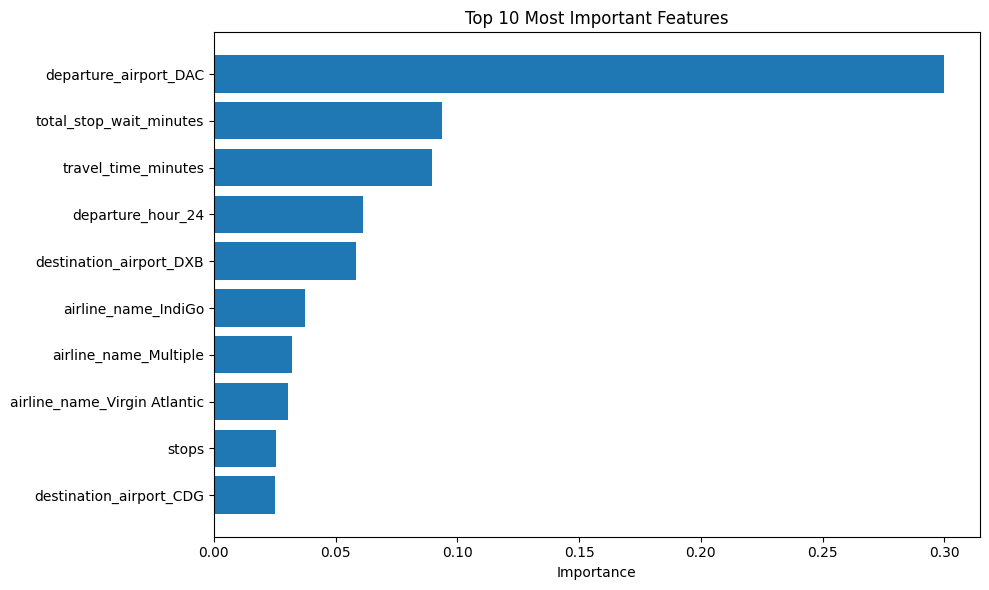

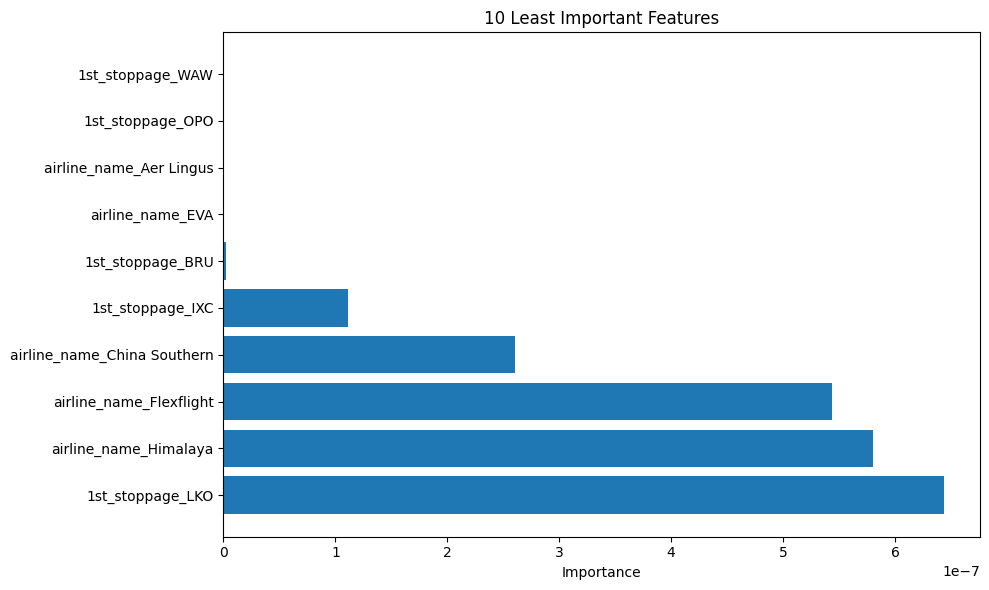

In [37]:
priceline_rf_model = train_random_forest(X_pl, y_pl, True)

In [53]:
custom_grid = {
    'regressor__n_estimators': [10, 50, 100, 150, 200, 500],
    'regressor__max_depth': [2, 5, 10, 20],
    'regressor__min_samples_split': [2, 3, 5, 10],
    'regressor__max_features': ['sqrt', 'log2']
}

best_model_grid_pl, search_log_grid_pl = random_search_random_forest(X_pl, y_pl, scale_numeric=True, n_iter=50, cv=5, random_state=seed, param_distributions=custom_grid)



Iteration 26: MAE = 585.67, Params = {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 10}
Iteration 24: MAE = 585.81, Params = {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 10}
Iteration 18: MAE = 586.16, Params = {'regressor__n_estimators': 150, 'regressor__min_samples_split': 10, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 5}
Iteration 20: MAE = 587.54, Params = {'regressor__n_estimators': 100, 'regressor__min_samples_split': 10, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 5}
Iteration 3: MAE = 589.16, Params = {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__max_features': 'log2', 'regressor__max_depth': 5}
Iteration 49: MAE = 589.34, Params = {'regressor__n_estimators': 150, 'regressor__min_samples_split': 2, 'regressor__max_features': 'log2', 'regressor__max_depth'

In [54]:
custom_grid_range = {
    'regressor__n_estimators': randint(50, 500),
    'regressor__max_depth': randint(5, 30),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 5),
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__bootstrap': [True, False],
    'regressor__ccp_alpha': uniform(0.0, 0.05)
}


best_model_range_pl, search_log_range_pl = random_search_random_forest(X_pl, y_pl, scale_numeric=True, n_iter=50, cv=5, random_state=seed, param_distributions=custom_grid_range)

Iteration 47: MAE = 572.73, Params = {'regressor__bootstrap': True, 'regressor__ccp_alpha': np.float64(0.017460478730633045), 'regressor__max_depth': 20, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 201}
Iteration 22: MAE = 572.83, Params = {'regressor__bootstrap': True, 'regressor__ccp_alpha': np.float64(0.019146343737689493), 'regressor__max_depth': 19, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 54}
Iteration 1: MAE = 573.08, Params = {'regressor__bootstrap': True, 'regressor__ccp_alpha': np.float64(0.039827149343011646), 'regressor__max_depth': 19, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 70}
Iteration 44: MAE = 573.37, Params = {'regressor__bootstrap': True, 'regressor__ccp_alpha': np.float64(0.027072398691378292), 'regres

## Flight Delay Data

In [67]:

def clean_delay_dataframe(df, target_column, encode=False):
    # Drop specified columns
    columns_to_drop = [
        'scheduleddepartdatetime',
        'originairportid',
        'destairportid',
        'tailnum',
        'origincityname',
        'originstate'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Drop rows where depdelay is null
    df = df[df['depdelay'].notnull()]

    # Impute numeric columns with mean
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].mean())

    # One-hot encode categorical columns
    if encode:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    else:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        df = df.drop(columns=categorical_cols, errors='ignore')
        
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    return X, y


In [76]:
df2 = pd.read_csv("delay_data_clean_no_encode.csv")
df2 = df2.drop(columns="arrdelay") # Dropping this column due to data leakage when predicting depdelay
# Generating a random sample of 100k to make the data more manageable.
df2_samp = df2.sample(n=25000, random_state=seed)

In [77]:
X_delay, y_delay = clean_delay_dataframe(df2_samp, 'depdelay', encode=False)

Training MAE: 6.87
Mean CV MAE: 18.58
CV MAE Std Dev: 0.18


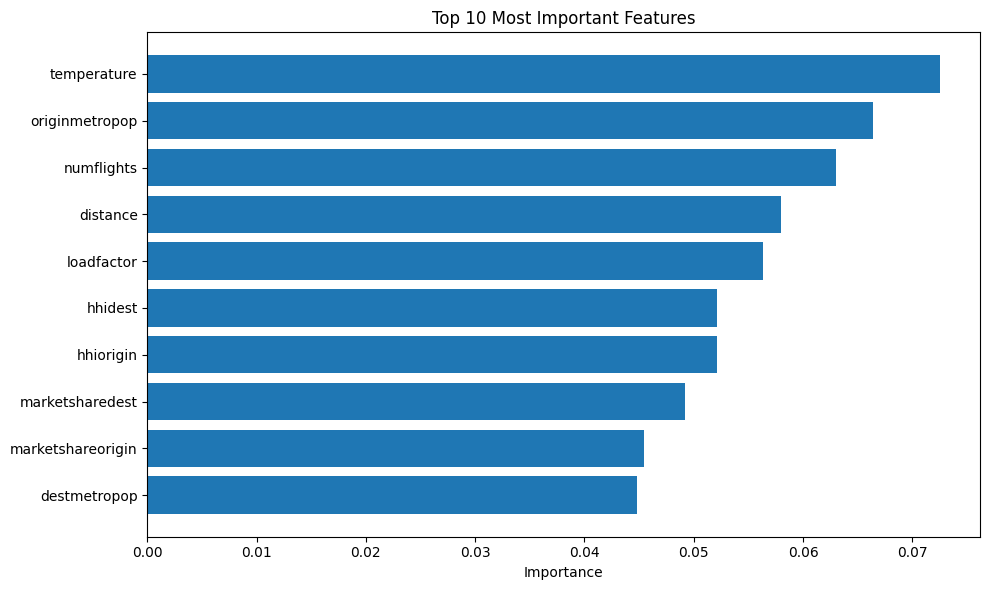

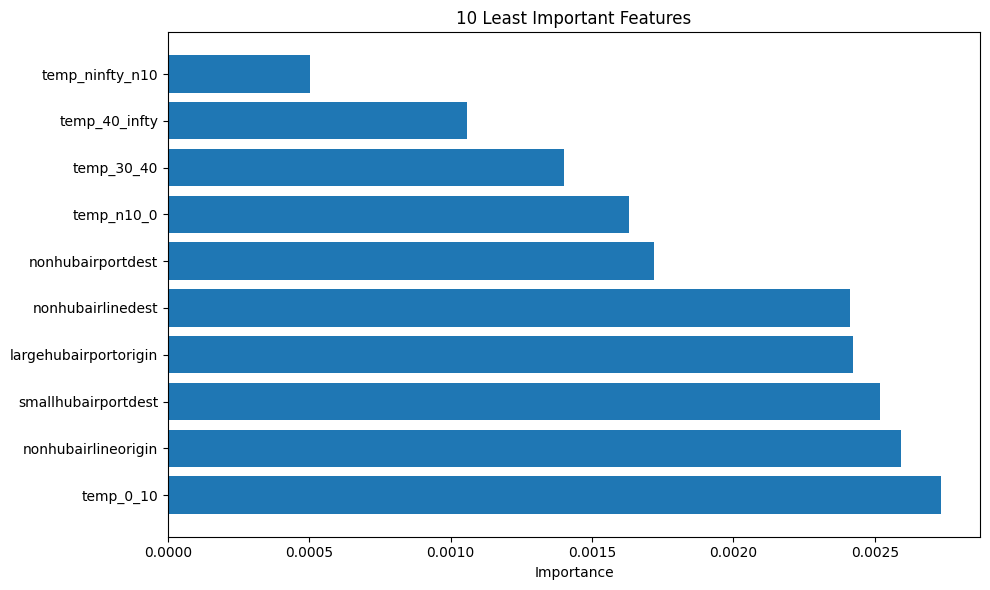

In [78]:
delay_rf_model = train_random_forest(X_delay, y_delay, True)

In [ ]:
custom_grid = {
    'regressor__n_estimators': [10, 50, 100, 150, 200, 500],
    'regressor__max_depth': [2, 5, 10, 20],
    'regressor__min_samples_split': [2, 3, 5, 10],
    'regressor__max_features': ['sqrt', 'log2']
}

best_model_grid_delay, search_log_grid_delay = random_search_random_forest(X_delay, y_delay, scale_numeric=True, n_iter=20, cv=5, random_state=seed, param_distributions=custom_grid)



In [ ]:
custom_grid_range = {
    'regressor__n_estimators': randint(50, 500),
    'regressor__max_depth': randint(5, 30),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 5),
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__bootstrap': [True, False],
    'regressor__ccp_alpha': uniform(0.0, 0.05)
}


best_model_range_delay, search_log_range_delay = random_search_random_forest(X_delay, y_delay, scale_numeric=True, n_iter=50, cv=5, random_state=seed, param_distributions=custom_grid_range)

## USDOT On-Time Data

In [85]:
def clean_ontime_dataframe(df, target_variable, encode=False):
    # List of columns to drop
    columns_to_drop = [
        'fl_date', 'op_carrier_airline_id', 'op_carrier', 'tail_num', 'op_carrier_fl_num',
        'origin_airport_id', 'origin)airport_seq_id', 'origin_city_market_id', 'origin_city_name',
        'origin_state_abr', 'origin_state_fips', 'origin_state_nm', 'dest_airport_seq_id',
        'dest_city_market_id', 'dest_city_name', 'dest_state_abr', 'dest_state_fips', 'dest_state_nm',
        'dep_delay_new', 'dep_del15', 'dep_delay_group', 'dep_time_blk', 'arr_time', 'arr_delay',
        'arr_delay_new', 'arr_del15', 'arr_delay_group', 'arr_time_blk', 'cancellation_code',
        'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'
    ]

    # Drop specified columns if they exist in the DataFrame
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    # Drop columns that start with 'div'
    df = df.drop(columns=[col for col in df.columns if col.startswith('div')], errors='ignore')

    # Drop columns where more than 95% of the values are null
    threshold = 0.95
    df = df.dropna(axis=1, thresh=int((1 - threshold) * len(df)))

    # Mean imputation for missing values
    df = df.fillna(df.mean(numeric_only=True))

        # One-hot encode categorical columns
    if encode:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    else:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        df = df.drop(columns=categorical_cols, errors='ignore')

    # Separate features and target
    y = df[target_variable]
    X = df.drop(columns=[target_variable])

    return X, y


In [86]:
df3 = pd.read_csv("usdot_onetime_clean_no_encode.csv", low_memory=False)
#df2 = df2.drop(columns="arrdelay") # Dropping this column due to data leakage when predicting depdelay
# Generating a random sample of 100k to make the data more manageable.
df3_clean = df3.dropna(axis=1, how='all') 
df3_samp = df3_clean.sample(n=25000, random_state=42)

In [87]:
X_ontime, y_ontime = clean_ontime_dataframe(df3_samp, 'dep_delay')

Training MAE: 1.40
Mean CV MAE: 4.22
CV MAE Std Dev: 0.33


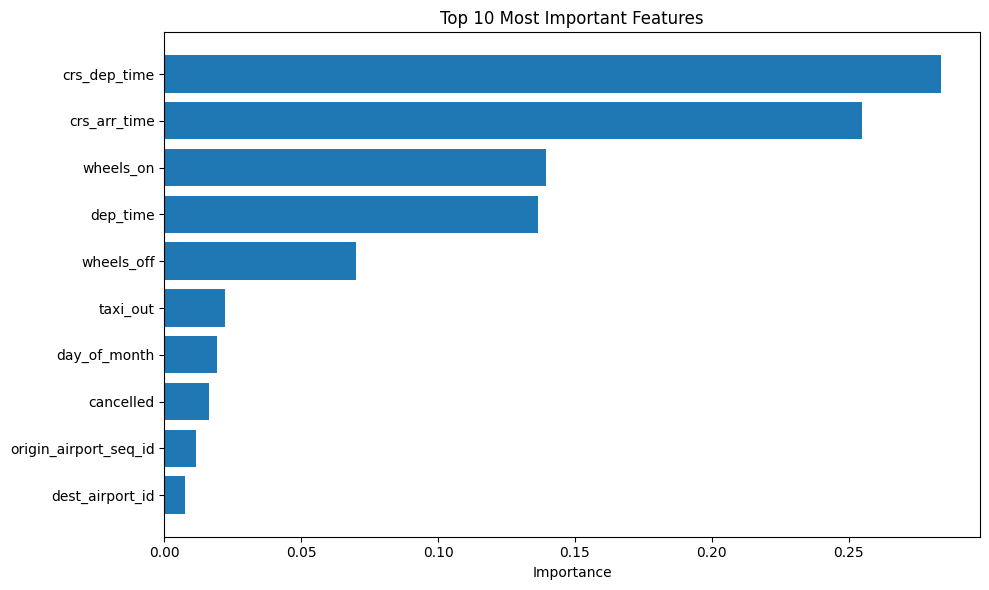

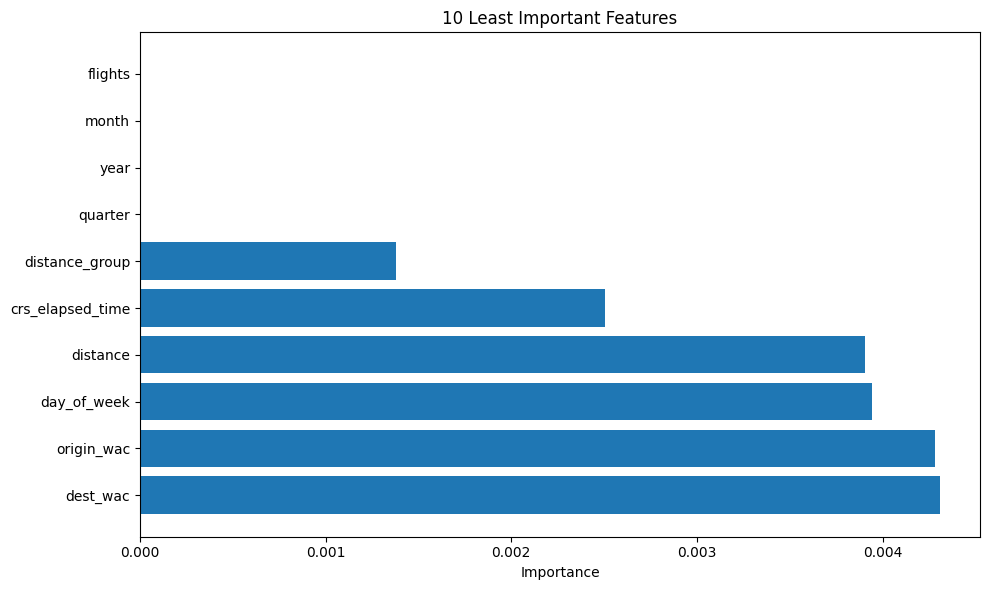

In [88]:
ontime_rf_model = train_random_forest(X_ontime, y_ontime, True)

In [ ]:
custom_grid = {
    'regressor__n_estimators': [10, 50, 100, 150, 200, 500],
    'regressor__max_depth': [2, 5, 10, 20],
    'regressor__min_samples_split': [2, 3, 5, 10],
    'regressor__max_features': ['sqrt', 'log2']
}

best_model_grid_ontime, search_log_grid_ontime = random_search_random_forest(X_ontime, y_ontime, scale_numeric=True, n_iter=20, cv=5, random_state=seed, param_distributions=custom_grid)



In [ ]:
custom_grid_range = {
    'regressor__n_estimators': randint(50, 500),
    'regressor__max_depth': randint(5, 30),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 5),
    'regressor__max_features': ['sqrt', 'log2'],
    'regressor__bootstrap': [True, False],
    'regressor__ccp_alpha': uniform(0.0, 0.05)
}


best_model_range_ontime, search_log_range_ontime = random_search_random_forest(X_ontime, y_ontime, scale_numeric=True, n_iter=50, cv=5, random_state=seed, param_distributions=custom_grid_range)